<a href="https://colab.research.google.com/github/pnkjsyngh/MLProjects/blob/main/CausalInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

We consider what factors cause a hotel booking to be cancelled.

There can be different reasons for why a booking is cancelled. A customer may have requested something that was not available (e.g., car parking), a customer may have found later that the hotel did not meet their requirements, or a customer may have simply cancelled their entire trip. Some of these like car parking are actionable by the hotel whereas others like trip cancellation are outside the hotel’s control. In any case, we would like to better understand which of these factors cause booking cancellations.

The gold standard of finding this out would be to use experiments such as Randomized Controlled Trials wherein each customer is randomly assigned to one of the two categories i.e. each customer is either assigned a car parking or not. However, such an experiment can be too costly and also unethical in some cases (for example, a hotel would start losing its reputation if people learn that its randomly assigning people to different level of service).

Can we somehow answer our query using only observational data or data that has been collected in the past?

## Import Libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dowhy

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Feature engineering

In [3]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

Ceating some new and meaningful features so as to reduce the dimensionality of the dataset.
- **Total Stay** = stays_in_weekend_nights + stays_in_week_nights
- **Guests** = adults + children + babies
- **Different_room_assigned** = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.

In [4]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

We also remove other columns that either contain NULL values or have too many unique values (e.g., agent ID). We also impute missing values of the country column with the most frequent country. We remove distribution_channel since it has a high overlap with market_segment.

In [5]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

We subsequently drop the columns that we seem not relevant to the analysis

In [6]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

Changing the categorical values to True and False

In [7]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
dataset.head(5)

<ipython-input-7-1c68c6bc2c92>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
<ipython-input-7-1c68c6bc2c92>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['is_canceled']= dataset['is_canceled'].replace(0,False)


,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


In [8]:
dataset_copy = dataset.copy(deep=True)

## Causal Analysis

### Step-1. Create a Causal Graph

Represent your prior knowledge about the predictive modelling problem as a CI graph using assumptions.

Here are a list of assumptions that have then been translated into a Causal Diagram:-

- Market Segment has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).

- Country would also play a role in deciding whether a person books early or not (hence more Lead Time) and what type of Meal a person would prefer.

- Lead Time would definitely affected the number of Days in Waitlist (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher Lead Times can also lead to Cancellations.

- The number of Days in Waitlist, the Total Stay in nights and the number of Guests might affect whether the booking is cancelled or retained.

- Previous Booking Retentions would affect whether a customer is a or not. Additionally, both of these variables would affect whether the booking get cancelled or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).

- Booking Changes would affect whether the customer is assigned a different room or not which might also lead to cancellation.

- Finally, the number of Booking Changes being the only variable affecting Treatment and Outcome is highly unlikely and its possible that there might be some Unobsevered Confounders, regarding which we have no information being captured in our data.

In [10]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled;
country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

/usr/local/lib/python3.11/dist-packages/dowhy/causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


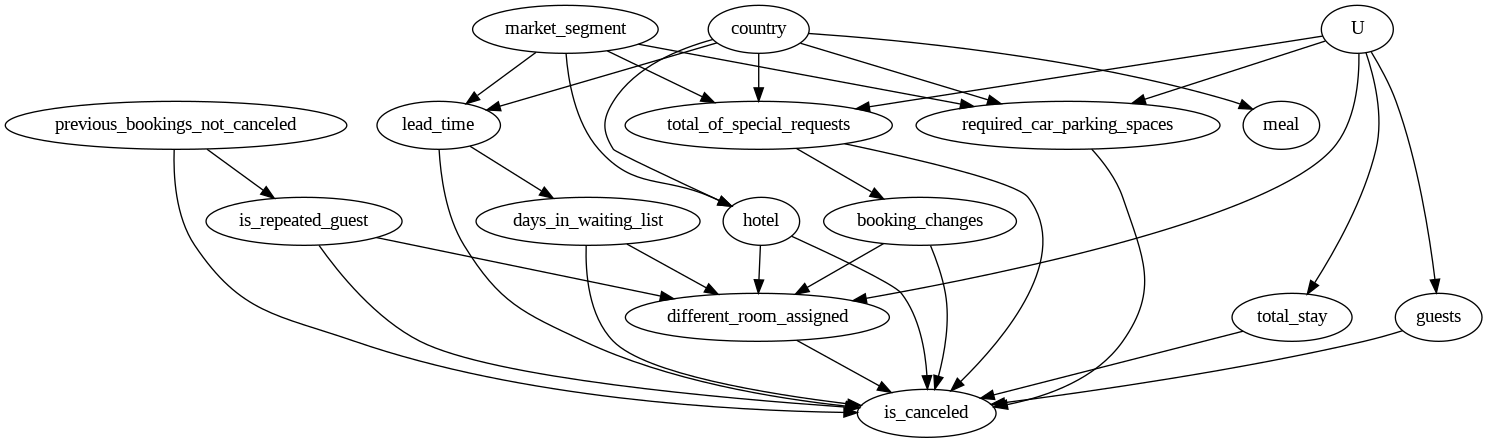

In [11]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
# model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### Step-2. Identify the Causal Effect

We say that Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant. Thus in this step, by using properties of the causal graph, we identify the causal effect

In [12]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                  ↪
──────────────────────────(E[is_canceled|booking_changes,total_stay,hotel,lead ↪
d[different_room_assigned]                                                     ↪

↪                                                                              ↪
↪ _time,required_car_parking_spaces,guests,is_repeated_guest,total_of_special_ ↪
↪                                                                              ↪

↪                                
↪ requests,days_in_waiting_list])
↪                                
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,total_stay,hotel,lead_time,required_car_parking_spaces,guests,is_repeated_guest,total_of_special_requests,days_in_waiting_list,U) = P(is_canceled|differ

### Step-3. Estimate the identified estimand

In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",
                                 target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                  ↪
──────────────────────────(E[is_canceled|booking_changes,total_stay,hotel,lead ↪
d[different_room_assigned]                                                     ↪

↪                                                                              ↪
↪ _time,required_car_parking_spaces,guests,is_repeated_guest,total_of_special_ ↪
↪                                                                              ↪

↪                                
↪ requests,days_in_waiting_list])
↪                                
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,total_stay,hotel,lead_time,required_car_parking_spaces,guests,is_repeated_guest,total_of_special_request

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


E(is_cancelled|different_room_assigned = 1) - E(is_cancelled|different_room_assigned = 0) = -0.262

It means that having a different room assigned decreases the chances of a cancellation.

One follow up question:
- Perhaps assigning a different room only happens at check-in, and the chances of a cancellation once the customer is already at the hotel are low. So having an additional feature on how long before the check-in the different room was assigned

### Step-4. Refute results

Placebo Treatment Refuter:- Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [14]:
refute_placebo_results=model.refute_estimate(identified_estimand,
                                      estimate,
                                      method_name="placebo_treatment_refuter",
                                      placebo_type="permute")
print(refute_placebo_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.3446814919371433
New effect:0.09383336068733515
p value:0.0

